# Imports

In [25]:
from typing import TypedDict, Optional, Dict,Annotated ,List ,Literal
from langgraph.graph import StateGraph ,START,END
from langchain_openai import ChatOpenAI
from langchain_groq import  ChatGroq
from langchain.prompts import PromptTemplate
from langgraph.graph.message import  add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import  MessagesState
from langchain_core.messages import HumanMessage,SystemMessage ,AnyMessage, AIMessage
from pydantic import  BaseModel,Field
from Prompts import  Prompts

# Utilities

In [26]:
def pretty_print(messages):
    print("="*50)
    print("MESSAGES PRETTY PRINTED") 
    print("="*50)
    for msg in messages:
        print("="*50)
        print(msg)
        print("="*50)

# Enviornment Vars

In [27]:
KRUTRIM_API_KEY="LNDn2rbGUIGZznn1NXT7U4VcADf-d"
KRUTRIM_ENDPOINT="https://cloud.olakrutrim.com/v1"
MODEL_NAME="Llama-3.3-70B-Instruct"
EVALUATION_MODEL_NAME="Llama-3.3-70B-Instruct"
GROQ_API_KEY="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"
GROQ_MODEL_NAME="llama-3.3-70b-versatile"

# Krutrim LLM

In [7]:
llm = ChatOpenAI(api_key=KRUTRIM_API_KEY, base_url=KRUTRIM_ENDPOINT, model=MODEL_NAME)
evaluation_llm= ChatOpenAI(api_key=KRUTRIM_API_KEY,base_url= KRUTRIM_ENDPOINT, model =EVALUATION_MODEL_NAME)
evaluation_llm=evaluation_llm.with_structured_output(schema=Decision)

# GROQ LLM

In [8]:
groq_llm= ChatGroq(groq_api_key=GROQ_API_KEY,model_name= GROQ_MODEL_NAME)
groq_evaluation_llm= ChatGroq(groq_api_key=GROQ_API_KEY,model =GROQ_MODEL_NAME)
groq_evaluation_llm=groq_evaluation_llm.with_structured_output(schema=Decision)

# Pydantic Models

In [6]:
class Decision(BaseModel):
    state: Annotated[Literal["Complete", "Incomplete"], Field(description="Anlyse the conversation correctly")]

In [9]:
class BuisnessNeedPreProcessed(BaseModel):    
    messages:Optional[Annotated[List[AnyMessage], add_messages, Field(description="Conversations as stored")]]=None
    processed_technical_conversions:Optional[Annotated[List[str],Field(description="")]] = None

# Codd State

In [10]:
class CoddState(BaseModel):
    business_need: Optional[Annotated[BuisnessNeedPreProcessed, Field(description="Original raw business need text as provided by the client")]] = None

# Nodes of graph

In [11]:
def human_input_node(state:CoddState):
    print("HUMAN INPUT NODE") 
    print("="*20)   
    human_input =input("Enter the follow up :")   
    print(f'The human input message is {HumanMessage(content=human_input)}')
    return {
        "business_need":{
            "messages":state.business_need.messages + [HumanMessage(content=human_input)]
        }
    }

In [12]:
def llm_node(state: CoddState):
    print("LLM INPUT NODE") 
    print("="*20 +"\n"*5)   
    response = groq_llm.invoke(state.business_need.messages)
    print(f'The response is : {response}')
    print(f'Type of the response is : {type(response)}')
    return {
        "business_need":{ 
            "messages": state.business_need.messages + [response]
        }   
    }

In [ ]:
def technical_pre_processing_node(state:CoddState):
    return {
        "business_need":{ 
            "messages": state.business_need.message,
            "processed_technical_conversions":[]
        }   
    }

In [24]:
def techincal_pre_node(state:CoddState):
    pass

# Edges of Graph

In [15]:
def routing_function(state: CoddState):
    print("ROUTING FUNCTION")
    print("="*20 + "\n"*5 )   
    print("CURRENT CONVERSATION:")
    pretty_print(state.business_need.messages)
    print("="*20 + "\n"*5 )
    print( f"The state business need is of type {type(state.business_need)}")
    print( f"The state business need is {state.business_need}")
    print("="*20)
    print(f"The state busineess need messages is of type {type(state.business_need.messages)}")
    print(f"The state busineess need messages is {state.business_need.messages}")
    print("="*20)
    if state.business_need and state.business_need.messages:
        conversation_transcript = "\n".join(
            [msg.content for msg in state.business_need.messages]
        )
        print(f"The conversation transcript is simply: {conversation_transcript}")
        evaluation_prompt =  Prompts.gen_conversation_evaluation().format(
            conversation_transcript=conversation_transcript
        )
        evaluation_response = groq_evaluation_llm.invoke(evaluation_prompt)
        print(f"The evaluation response is {evaluation_response}")
        if evaluation_response.state == 'Complete':
            return END
        else:
            return "human_input_node"
    return "human_input_node"


# Config Thread

In [16]:
config = {"configurable": {"thread_id": "abc123"}}

# Graph of the workflow

#### Worflow added

In [17]:
workflow = StateGraph(state_schema=CoddState)

#### Add Nodes

In [18]:
workflow.add_node("human_input_node",human_input_node)
workflow.add_node("llm_node", llm_node)

#### Add Edges

In [19]:
workflow.add_edge(START, "human_input_node")
workflow.add_edge("human_input_node","llm_node")
workflow.add_conditional_edges("llm_node", routing_function)

#### Complie the Workflow with memory

In [20]:
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

# Display the graph

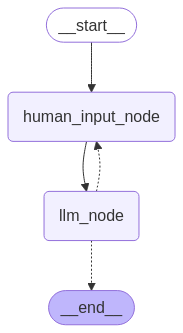

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Test and Run it 

### Run on same Thread

In [ ]:
input_messages = [SystemMessage(Prompts.gen_analysis_business_need())]
print(input_messages) 
print("="*20)   
try:
    output = graph.invoke({"business_need": {"messages":input_messages}}, config)
except Exception as err:
    print(err)

# Make the Techincal Pre Processing